In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib as mpl
import BiGLasso_Methods as bg
import GmGM
import scipy.stats as stats
import scipy.sparse as sparse
import igraph as ig
from strong_product_model import strong_product_model

import os

# Prevent type 3 fonts
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
# Load data
# Get all types of objects
data_dir = 'data/coil-20-proc/'
headers = {x.split('__')[0] for x in os.listdir(data_dir)}
print(headers)

{'obj18', 'obj8', 'obj5', 'obj4', 'obj17', 'obj11', 'obj13', 'obj20', 'obj1', 'obj7', 'obj3', 'obj2', 'obj10', 'obj15', 'obj19', 'obj16', 'obj6', 'obj9', 'obj14', 'obj12'}


In [4]:
# Every object has 72 frames, with 128x128 pixels
data: dict[str, np.ndarray] = {}
for object in headers:
    # Get all images of the object
    images = [x for x in os.listdir(data_dir) if x.split('__')[0] == object]
    frame_numbers = [int(x.split('__')[1].split('.')[0]) for x in images]
    data[object] = np.ndarray((len(images), 128, 128))
    for i, image in zip(frame_numbers, images):
        data[object][i] = plt.imread(data_dir + image)

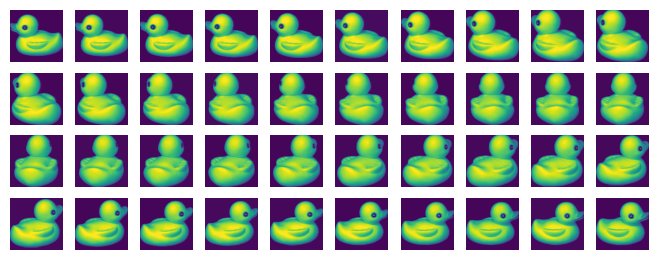

In [5]:
fig, axs = plt.subplots(ncols=10, nrows=4)
for i, ax in enumerate(axs.flatten()):
    ax.imshow(data['obj1'][i])
    ax.axis('off')
# lower remove margins
fig.subplots_adjust(left=0, right=1, top=1, bottom=0.5)

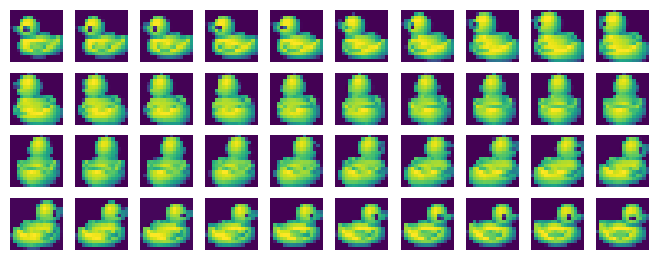

In [6]:
# Downsample images to be 16x16
data_downsampled = {object: np.array([x[::8, ::8] for x in data[object]]) for object in data}

fig, axs = plt.subplots(ncols=10, nrows=4)
for i, ax in enumerate(axs.flatten()):
    ax.imshow(data_downsampled['obj1'][i])
    ax.axis('off')
# lower remove margins
fig.subplots_adjust(left=0, right=1, top=1, bottom=0.5)

In [7]:
# Flatten images to be 1D
data_flattened = {
    object: data_downsampled[object].reshape((72, -1))
    for object in data_downsampled
}

# Strong Product Model

In [8]:
# Run through strong_product_model

results_sp = strong_product_model(
    data_matrix=data_flattened['obj1'] - data_flattened['obj1'].mean(),
    rho_rows=0.1,
    rho_cols_within_rows=0.1,
    rho_cols_between_rows=0.1,
    verbose=True,
    tol=1e-3
)

Iteration 1: -15430.682538830497
Iteration 2: -15859.773383447335
Iteration 3: -15905.706362236033
Iteration 4: -15928.27402649177
Iteration 5: -15933.87087826506
Iteration 6: -15936.663381728447
Iteration 7: -15937.012111383683
Iteration 8: -15937.186453216858
Iteration 9: -15937.230035985174
Iteration 10: -15937.25182701019
Iteration 11: -15937.253188939283
Iteration 12: -15937.253869903474 (converged)


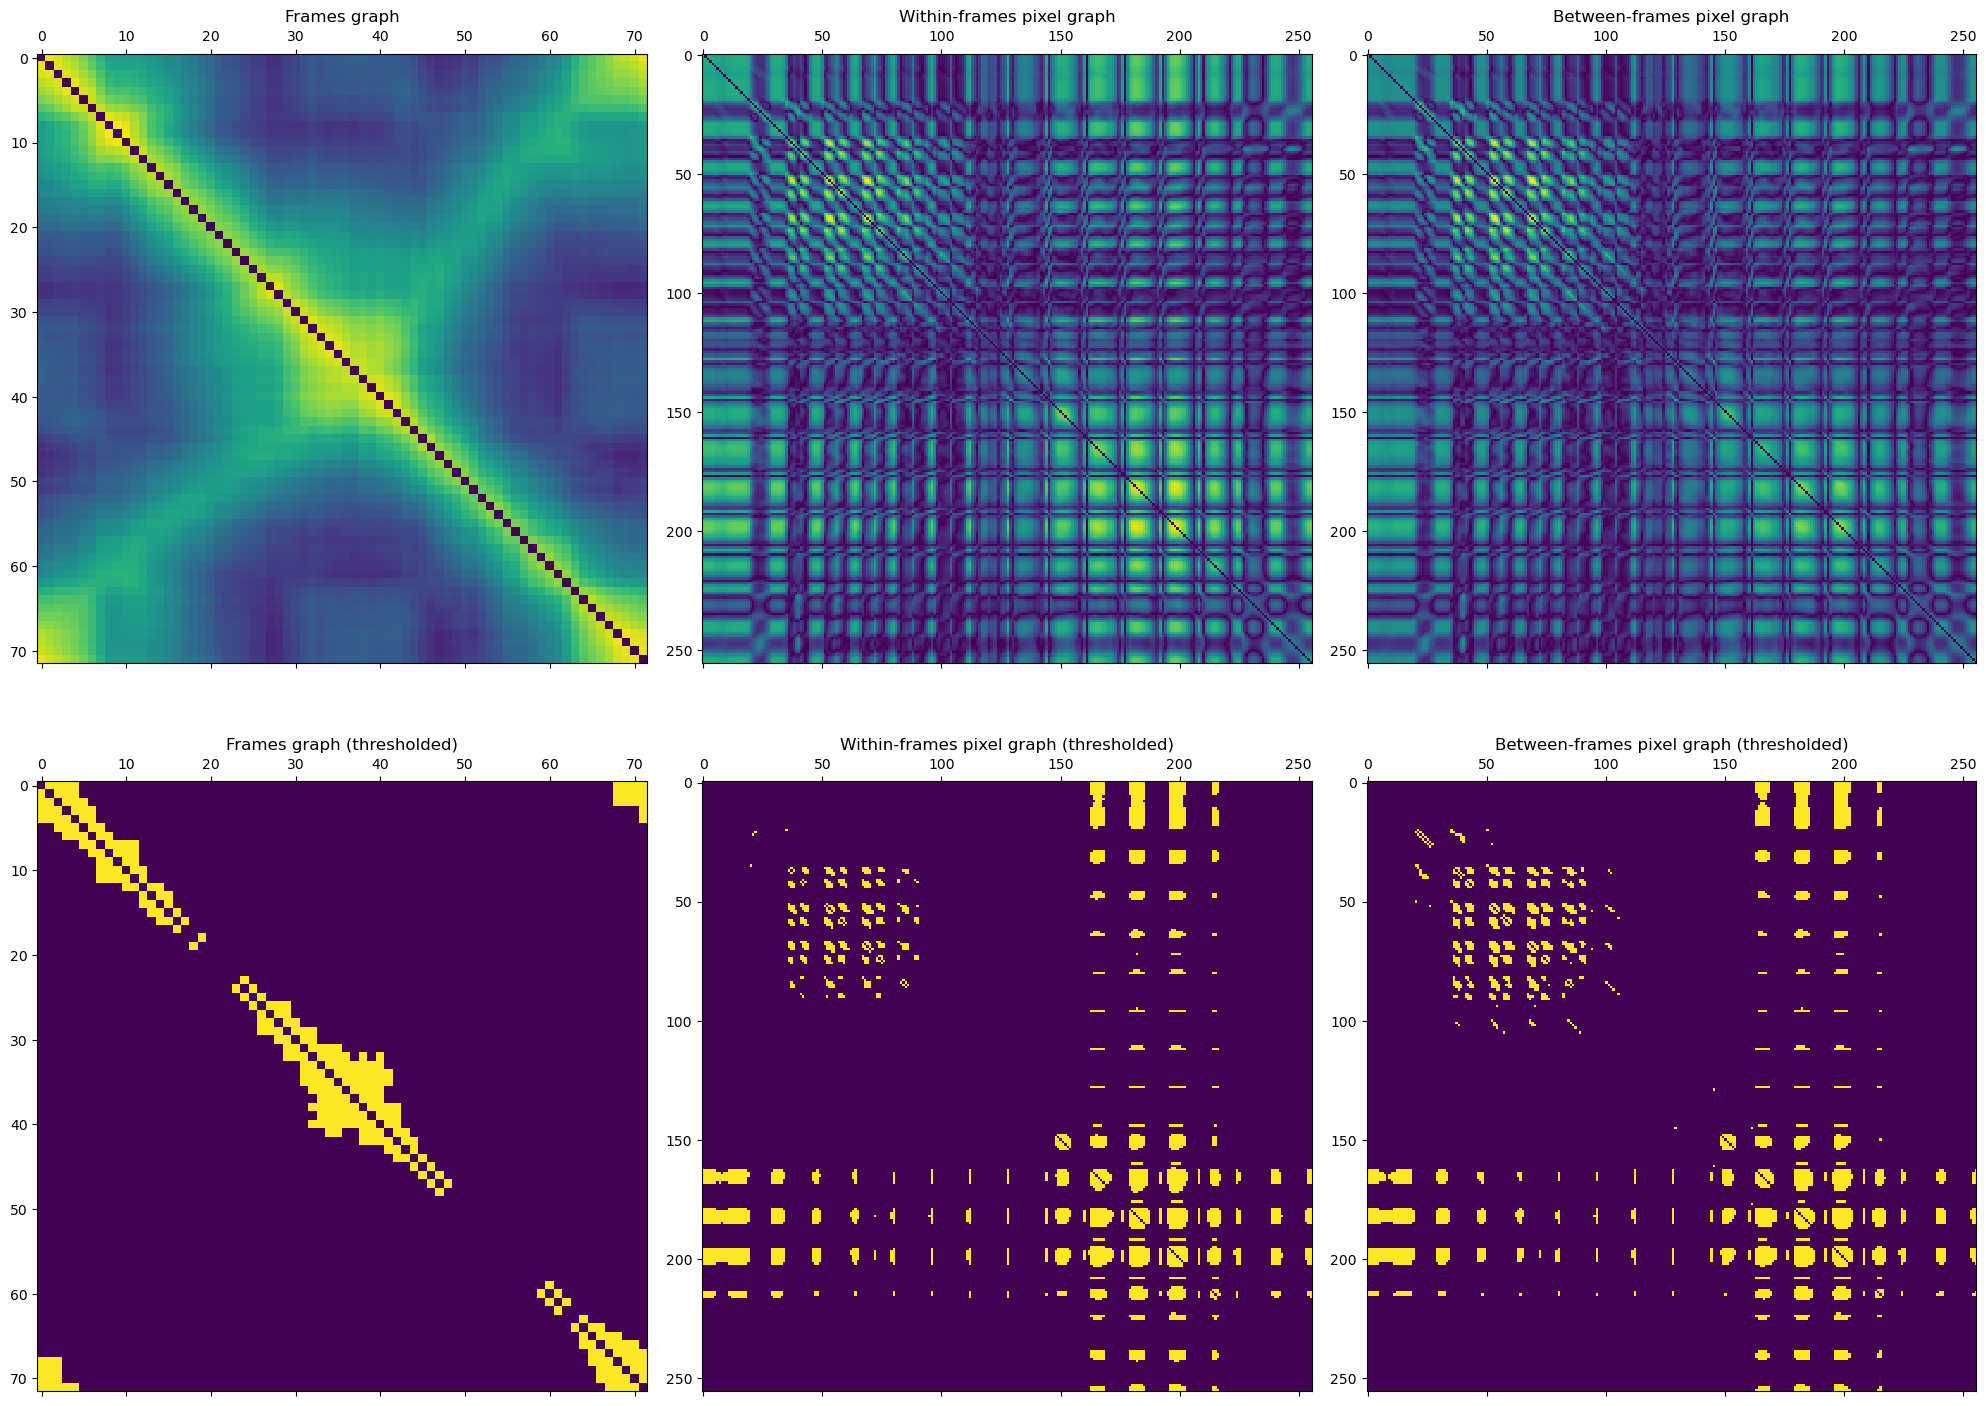

In [9]:
resmatrix_sp = np.abs(results_sp['rows'])
np.fill_diagonal(resmatrix_sp, 0)
resmatrix_cols_within = np.abs(results_sp['cols_within_rows'])
resmatrix_cols_between = np.abs(results_sp['cols_between_rows'])
np.fill_diagonal(resmatrix_cols_within, 0)
np.fill_diagonal(resmatrix_cols_between, 0)

# Keep only the top 2 edges per node
to_keep = 72 * 2
num_edges = (72 ** 2 - 72) / 2
percentile = 100 - to_keep / num_edges * 100
threshold = np.percentile(resmatrix_sp, percentile)
#resmatrix_sp[resmatrix_sp < threshold] = 0

# Keep other graphs at same percentile
threshold_cols_within = np.percentile(resmatrix_cols_within, percentile)
threshold_cols_between = np.percentile(resmatrix_cols_between, percentile)
#resmatrix_cols_within[resmatrix_cols_within < threshold_cols_within] = 0
#resmatrix_cols_between[resmatrix_cols_between < threshold_cols_between] = 0

fig, axs = plt.subplots(ncols=3, figsize=(20, 15), nrows=2)
ax1, ax2, ax3 = axs[0]
ax1.matshow(resmatrix_sp)
ax1.set_title("Frames graph")
ax2.matshow(resmatrix_cols_within)
ax2.set_title("Within-frames pixel graph")
ax3.matshow(resmatrix_cols_between)
ax3.set_title("Between-frames pixel graph")

ax4, ax5, ax6 = axs[1]
resmatrix_sp[resmatrix_sp < threshold] = 0
resmatrix_cols_within[resmatrix_cols_within < threshold_cols_within] = 0
resmatrix_cols_between[resmatrix_cols_between < threshold_cols_between] = 0
resmatrix_sp[resmatrix_sp != 0] = 1
resmatrix_cols_within[resmatrix_cols_within != 0] = 1
resmatrix_cols_between[resmatrix_cols_between != 0] = 1
ax4.matshow(resmatrix_sp)
ax4.set_title("Frames graph (thresholded)")
ax5.matshow(resmatrix_cols_within)
ax5.set_title("Within-frames pixel graph (thresholded)")
ax6.matshow(resmatrix_cols_between)
ax6.set_title("Between-frames pixel graph (thresholded)")

# for (i, j), z in np.ndenumerate(frames_res):
#     ax1.text(
#         j,
#         i,
#         '{:0.1f}'.format(z),
#         ha='center',
#         va='center',
#         bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3')
#     )

fig.tight_layout()
fig.savefig('out_figs/coil/sp-precisions.pdf', bbox_inches='tight')

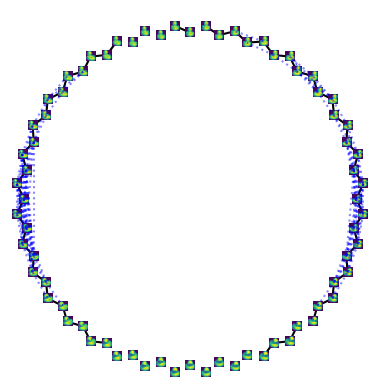

In [10]:
fig, ax = plt.subplots()
ax.axis('off')


for i in range(72):
    for j in range(72):
        if i >= j:
            continue
        if resmatrix_sp[i, j] != 0:
            angle_1 = i/72 * 2 * np.pi
            angle_2 = j/72 * 2 * np.pi
            scale_i = 450 +  + 20 * (i % 2)
            scale_j = 450 +  + 20 * (j % 2)
            xs = [scale_i * np.cos(angle_1) - 0.2*64, scale_j * np.cos(angle_2) - 0.2*64]
            ys = [scale_i * np.sin(angle_1) - 0.2*64, scale_j * np.sin(angle_2) - 0.2*64]
            if np.abs(i - j) == 1 or np.abs(i - j) == 71:
                ax.plot(xs, ys, color='black', zorder=0)
            else:
                ax.plot(xs, ys, color='#0000ff77', zorder=20, linestyle=':')

for i in range(72):
    img = ax.imshow(data["obj1"][i], zorder=10)
    transform_rot = mpl.transforms.Affine2D().rotate_deg(-i/72 * 360 + 180)
    transform_scale = mpl.transforms.Affine2D().scale(0.2, 0.2)
    transform_move = mpl.transforms.Affine2D().translate(450 + 20 * (i % 2), 0)
    transform_rerot = mpl.transforms.Affine2D().rotate_deg(i/72 * 360)
    img.set_transform(
        transform_rot
        + transform_scale
        + transform_move
        + transform_rerot
        + ax.transData
    )

ax.set_xlim(-500, 500)
ax.set_ylim(-500, 500)

fig.savefig('out_figs/coil/sp.pdf', transparent=True, dpi=200)

# Strong Product Model Transposed

In [11]:
# Run through strong_product_model

results_sp_t = strong_product_model(
    data_matrix=data_flattened['obj1'].T - data_flattened['obj1'].T.mean(),
    rho_rows=0.1,
    rho_cols_within_rows=0.1,
    rho_cols_between_rows=0.1,
    verbose=True,
    tol=1e-3,
)

Iteration 1: -15550.920891338883
Iteration 2: -16061.8343157281
Iteration 3: -16286.935946429494
Iteration 4: -16340.65223112845
Iteration 5: -16367.211336514283
Iteration 6: -16380.418644368914
Iteration 7: -16387.004539100417
Iteration 8: -16390.293083684195
Iteration 9: -16391.936259862778
Iteration 10: -16392.346925709586
Iteration 11: -16392.552241556907
Iteration 12: -16392.565073322163
Iteration 13: -16392.56828125568
Iteration 14: -16392.569885221368
Iteration 15: -16392.57068720397 (converged)


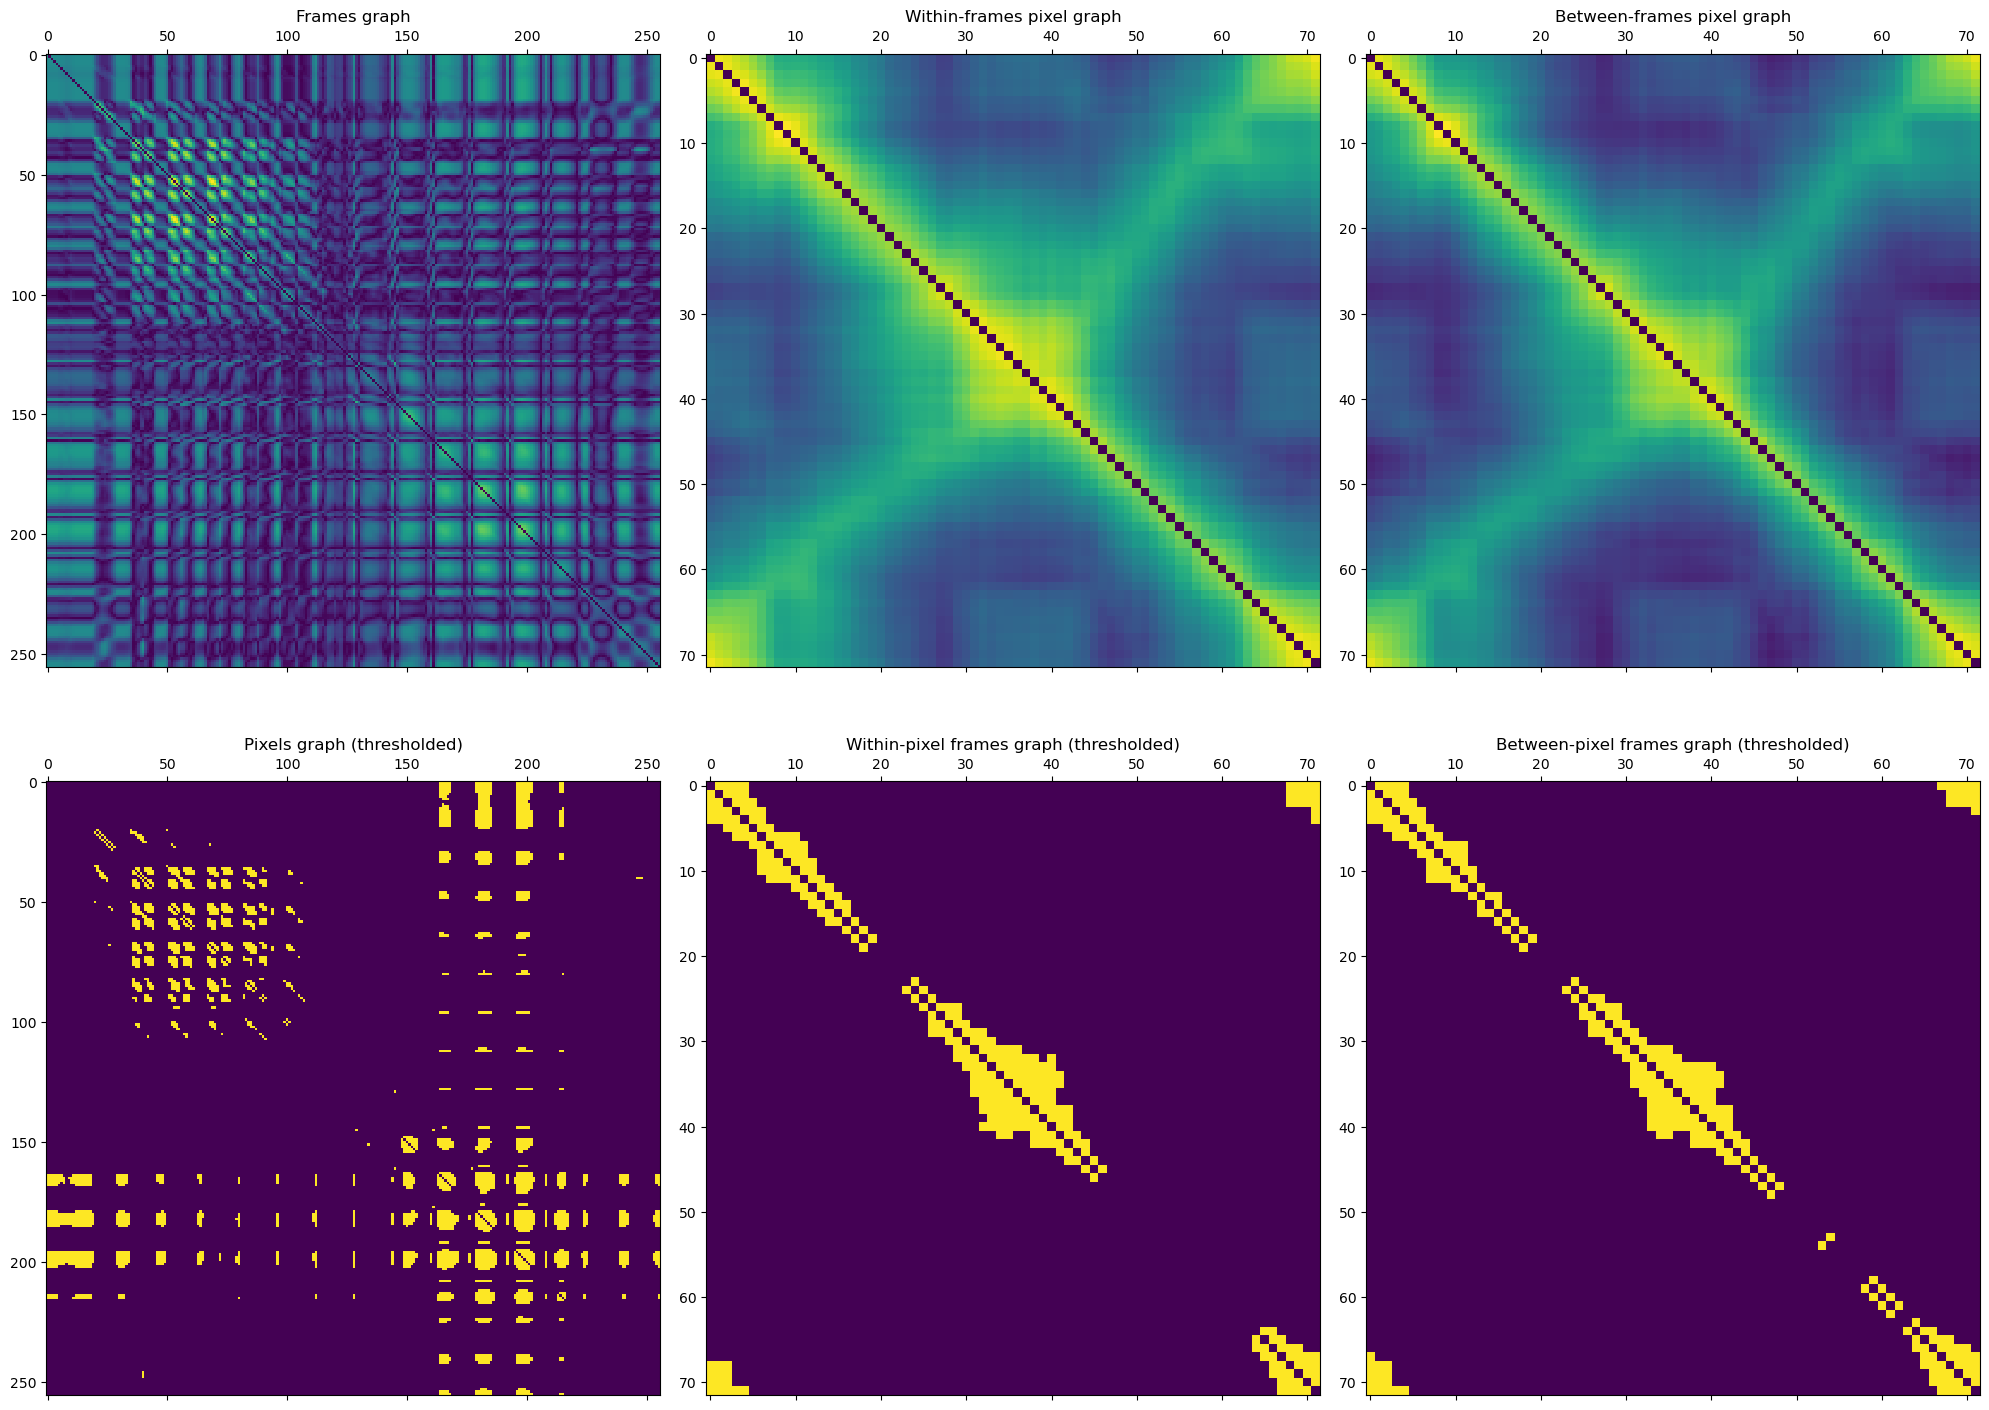

In [13]:
resmatrix_rows = np.abs(results_sp_t['rows'])
np.fill_diagonal(resmatrix_rows, 0)
resmatrix_cols_within = np.abs(results_sp_t['cols_within_rows'])
resmatrix_cols_between = np.abs(results_sp_t['cols_between_rows'])
np.fill_diagonal(resmatrix_cols_within, 0)
np.fill_diagonal(resmatrix_cols_between, 0)

# Keep only the top 2 edges per node
to_keep = 72 * 2
num_edges = (72 ** 2 - 72) / 2
percentile = 100 - to_keep / num_edges * 100
threshold = np.percentile(resmatrix_rows, percentile)
#resmatrix_sp[resmatrix_sp < threshold] = 0

# Keep other graphs at same percentile
threshold_cols_within = np.percentile(resmatrix_cols_within, percentile)
threshold_cols_between = np.percentile(resmatrix_cols_between, percentile)
#resmatrix_cols_within[resmatrix_cols_within < threshold_cols_within] = 0
#resmatrix_cols_between[resmatrix_cols_between < threshold_cols_between] = 0

fig, axs = plt.subplots(ncols=3, figsize=(20, 15), nrows=2)
ax1, ax2, ax3 = axs[0]
ax1.matshow(resmatrix_rows)
ax1.set_title("Frames graph")
ax2.matshow(resmatrix_cols_within)
ax2.set_title("Within-frames pixel graph")
ax3.matshow(resmatrix_cols_between)
ax3.set_title("Between-frames pixel graph")

ax4, ax5, ax6 = axs[1]
resmatrix_rows[resmatrix_rows < threshold] = 0
resmatrix_cols_within[resmatrix_cols_within < threshold_cols_within] = 0
resmatrix_cols_between[resmatrix_cols_between < threshold_cols_between] = 0
resmatrix_rows[resmatrix_rows != 0] = 1
resmatrix_cols_within[resmatrix_cols_within != 0] = 1
resmatrix_cols_between[resmatrix_cols_between != 0] = 1
ax4.matshow(resmatrix_rows)
ax4.set_title("Pixels graph (thresholded)")
ax5.matshow(resmatrix_cols_within)
ax5.set_title("Within-pixel frames graph (thresholded)")
ax6.matshow(resmatrix_cols_between)
ax6.set_title("Between-pixel frames graph (thresholded)")

# for (i, j), z in np.ndenumerate(frames_res):
#     ax1.text(
#         j,
#         i,
#         '{:0.1f}'.format(z),
#         ha='center',
#         va='center',
#         bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3')
#     )

fig.tight_layout()
fig.savefig('out_figs/coil/sp-t-precisions.pdf', bbox_inches='tight')

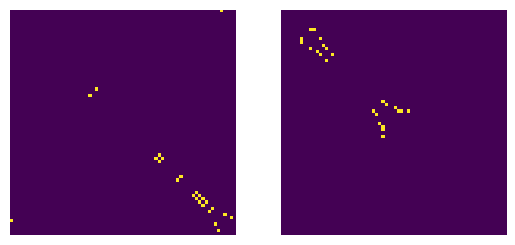

In [14]:
cbetw = resmatrix_cols_between.astype(bool)
cwith = resmatrix_cols_within.astype(bool)
cbetw = cbetw | cbetw.T
cwith = cwith | cwith.T

fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.axis('off')
ax1.matshow(cbetw & ~cwith)
ax2.axis('off')
ax2.matshow(~cbetw & cwith)

# GmGM

In [ ]:
dataset = GmGM.Dataset(
    dataset={'duck': data_flattened['obj1'] - data_flattened['obj1'].mean()},
    structure={
        'duck': (f'frame', f'pixel')
    },
    batch_axes=None
)

In [ ]:
results_gmgm = GmGM.GmGM(
    dataset,
    to_keep=1.0,
    threshold_method="overall",
    n_comps=None,
    verbose=True,
    centering_method=None,
    use_nonparanormal_skeptic=False,
    nonparanormal_evec_backend="COCA",
    readonly=False,
    calculate_explained_variance=True,
    batch_size=1000
).precision_matrices

Centering...
Calculating eigenvectors...
	by calculating gram matrices and then eigendecomposing...
Calculating eigenvectors for axis='frame'
Calculating eigenvectors for axis='pixel'
100% explained variance, since `n_comps` was not specified
Calculating eigenvalues...
@0: -16625.04308246164 (-16627.883388243485 + 2.8403057818427877 + 0) ∆inf
Converged! (@14: -19804.303051809697)
Recomposing sparse precisions...
Done!


Text(0.5, 1.0, 'Within-frames pixel graph (thresholded)')

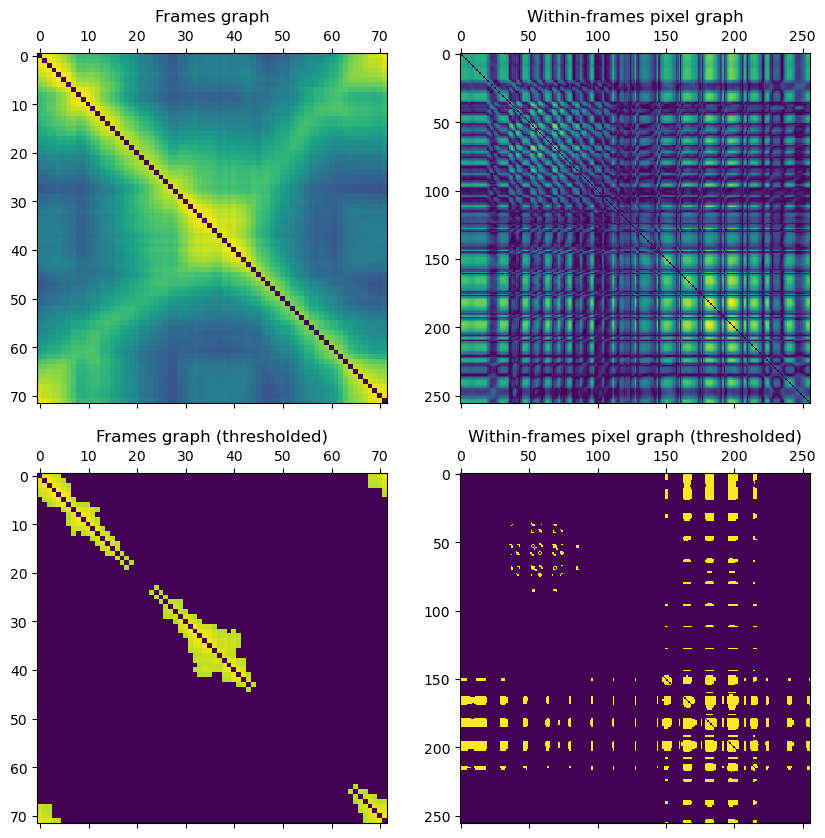

In [ ]:
resmatrix_gmgm = np.abs(results_gmgm['frame'].toarray())
np.fill_diagonal(resmatrix_gmgm, 0)
resmatrix_cols_within = np.abs(results_gmgm['pixel'].toarray())
np.fill_diagonal(resmatrix_cols_within, 0)

# Keep only the top 2 edges per node
to_keep = 72 * 2
num_edges = (72 ** 2 - 72) / 2
percentile = 100 - to_keep / num_edges * 100
threshold = np.percentile(resmatrix_gmgm, percentile)
#resmatrix_gmgm[resmatrix_gmgm < threshold] = 0

# Keep other graphs at same percentile
threshold_cols_within = np.percentile(resmatrix_cols_within, percentile)
#resmatrix_cols_within[resmatrix_cols_within < threshold_cols_within] = 0

fig, axs = plt.subplots(ncols=2, figsize=(10, 10), nrows=2)
ax1, ax2 = axs[0]
ax1.matshow(resmatrix_gmgm)
ax1.set_title("Frames graph")
ax2.matshow(resmatrix_cols_within)
ax2.set_title("Within-frames pixel graph")

ax4, ax5 = axs[1]
resmatrix_gmgm[resmatrix_gmgm < threshold] = 0
resmatrix_cols_within[resmatrix_cols_within < threshold_cols_within] = 0
resmatrix_sp[resmatrix_sp != 0] = 1
resmatrix_cols_within[resmatrix_cols_within != 0] = 1
ax4.matshow(resmatrix_gmgm)
ax4.set_title("Frames graph (thresholded)")
ax5.matshow(resmatrix_cols_within)
ax5.set_title("Within-frames pixel graph (thresholded)")

fig.tight_layout()
fig.savefig('out_figs/coil/gmgm-precisions.pdf', bbox_inches='tight')

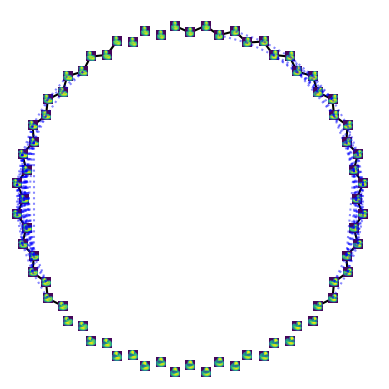

In [ ]:
fig, ax = plt.subplots()
ax.axis('off')


for i in range(72):
    for j in range(72):
        if i >= j:
            continue
        if resmatrix_gmgm[i, j] != 0:
            angle_1 = i/72 * 2 * np.pi
            angle_2 = j/72 * 2 * np.pi
            scale_i = 450 +  + 20 * (i % 2)
            scale_j = 450 +  + 20 * (j % 2)
            xs = [scale_i * np.cos(angle_1) - 0.2*64, scale_j * np.cos(angle_2) - 0.2*64]
            ys = [scale_i * np.sin(angle_1) - 0.2*64, scale_j * np.sin(angle_2) - 0.2*64]
            if np.abs(i - j) == 1 or np.abs(i - j) == 71:
                ax.plot(xs, ys, color='black', zorder=0)
            else:
                ax.plot(xs, ys, color='#0000ff77', zorder=20, linestyle=':')

for i in range(72):
    img = ax.imshow(data["obj1"][i], zorder=10)
    transform_rot = mpl.transforms.Affine2D().rotate_deg(-i/72 * 360 + 180)
    transform_scale = mpl.transforms.Affine2D().scale(0.2, 0.2)
    transform_move = mpl.transforms.Affine2D().translate(450 + 20 * (i % 2), 0)
    transform_rerot = mpl.transforms.Affine2D().rotate_deg(i/72 * 360)
    img.set_transform(
        transform_rot
        + transform_scale
        + transform_move
        + transform_rerot
        + ax.transData
    )

ax.set_xlim(-500, 500)
ax.set_ylim(-500, 500)

fig.savefig('out_figs/coil/gmgm.pdf', transparent=True, dpi=200)

# TeraLasso

In [ ]:
dataset_tera = GmGM.Dataset(
    dataset={'obj1': data_flattened['obj1'] - data_flattened['obj1'].mean()},
    structure={
        'obj1': (f'frame', f'pixel')
    },
    batch_axes=None
)
results_tera = bg.TeraLasso(
    dataset_tera,
    beta=0.128,
    use_nonparanormal_skeptic=False,
    tol=1e-3
)
results_tera

Dataset(
	obj1: ('frame', 'pixel')
)
Axes(
	frame: 72
		Prior: None
		Gram: Calculated
		Eig: Not calculated
	pixel: 256
		Prior: None
		Gram: Calculated
		Eig: Not calculated
)

138.0


Text(0.5, 1.0, 'Frames graph (thresholded)')

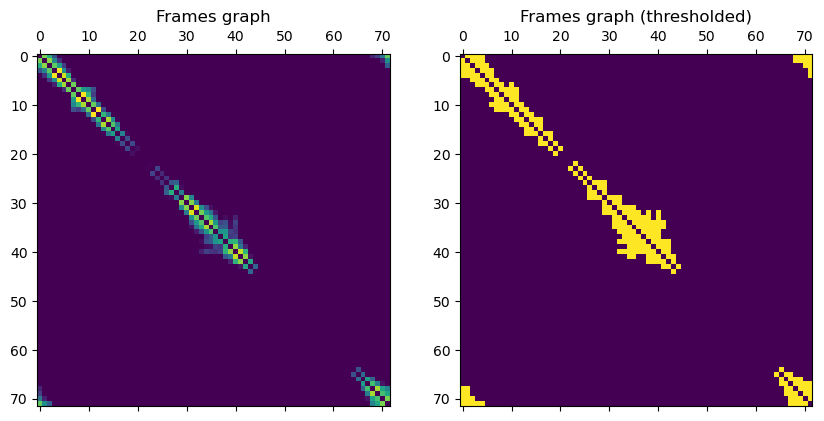

In [ ]:
# Create a random graph
resmatrix_tera = np.abs(results_tera.precision_matrices['frame'].toarray())
np.fill_diagonal(resmatrix_tera, 0)

# Keep only the top 144 of the edges
print((resmatrix_tera != 0).sum() / 2)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
ax1.matshow(resmatrix_tera)
ax1.set_title("Frames graph")
resmatrix_tera[resmatrix_tera != 0] = 1
ax2.matshow(resmatrix_tera)
ax2.set_title("Frames graph (thresholded)")

# for (i, j), z in np.ndenumerate(frames_res):
#     ax1.text(
#         j,
#         i,
#         '{:0.1f}'.format(z),
#         ha='center',
#         va='center',
#         bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3')
#     )

4046.0


Text(0.5, 1.0, 'Pixel graph (thresholded)')

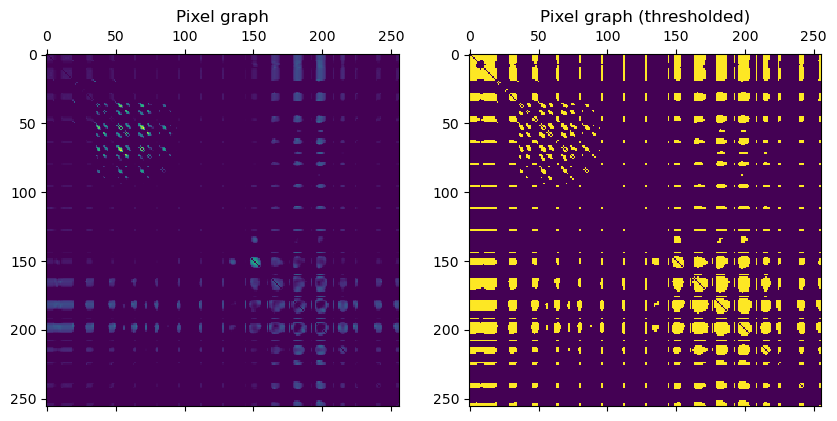

In [ ]:
# Create a random graph
resmatrix_tera_pixels = np.abs(results_tera.precision_matrices['pixel'].toarray())
np.fill_diagonal(resmatrix_tera_pixels, 0)

# Keep only the top 144 of the edges
print((resmatrix_tera_pixels != 0).sum() / 2)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
ax1.matshow(resmatrix_tera_pixels)
ax1.set_title("Pixel graph")
resmatrix_tera_pixels[resmatrix_tera_pixels != 0] = 1
ax2.matshow(resmatrix_tera_pixels)
ax2.set_title("Pixel graph (thresholded)")

# for (i, j), z in np.ndenumerate(frames_res):
#     ax1.text(
#         j,
#         i,
#         '{:0.1f}'.format(z),
#         ha='center',
#         va='center',
#         bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3')
#     )

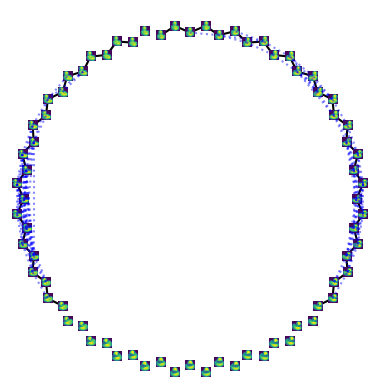

In [ ]:
fig, ax = plt.subplots()
ax.axis('off')


for i in range(72):
    for j in range(72):
        if i >= j:
            continue
        if resmatrix_tera[i, j] != 0:
            angle_1 = i/72 * 2 * np.pi
            angle_2 = j/72 * 2 * np.pi
            scale_i = 450 +  + 20 * (i % 2)
            scale_j = 450 +  + 20 * (j % 2)
            xs = [scale_i * np.cos(angle_1) - 0.2*64, scale_j * np.cos(angle_2) - 0.2*64]
            ys = [scale_i * np.sin(angle_1) - 0.2*64, scale_j * np.sin(angle_2) - 0.2*64]
            if np.abs(i - j) == 1 or np.abs(i - j) == 71:
                ax.plot(xs, ys, color='black', zorder=0)
            else:
                ax.plot(xs, ys, color='#0000ff77', zorder=20, linestyle=':')

for i in range(72):
    img = ax.imshow(data["obj1"][i], zorder=10)
    transform_rot = mpl.transforms.Affine2D().rotate_deg(-i/72 * 360 + 180)
    transform_scale = mpl.transforms.Affine2D().scale(0.2, 0.2)
    transform_move = mpl.transforms.Affine2D().translate(450 + 20 * (i % 2), 0)
    transform_rerot = mpl.transforms.Affine2D().rotate_deg(i/72 * 360)
    img.set_transform(
        transform_rot
        + transform_scale
        + transform_move
        + transform_rerot
        + ax.transData
    )

ax.set_xlim(-500, 500)
ax.set_ylim(-500, 500)

fig.savefig('out_figs/coil/tera.pdf', transparent=True, dpi=200)